In [9]:
#Khai báo các thư viện 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model # type: ignore

#Các lớp để xây dựng mô hình
from keras.models import Sequential #Đầu vào 
from keras.layers import LSTM #Học phụ thuộc
from keras.layers import Dropout# Tránh học tủ over fitting
from keras.layers import Dense #Đầu ra

#Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #Đo phần trăm sai số tuyệt đối trung bình 

import json
import time
import import_ipynb


In [12]:
import time
import os
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from kafka import KafkaProducer

In [14]:
import pandas as pd
from kafka import KafkaConsumer
import time
import io

def get_kafka():
    # Thời gian chờ (giây)
    timeout_duration = 10

    # Tạo Kafka Consumer
    consumer = KafkaConsumer(
        "n2_ict",
        bootstrap_servers='localhost:9092',
        auto_offset_reset='earliest',
        enable_auto_commit=False
    )

    # Danh sách để lưu trữ các tin nhắn
    messages = []

    # Thời gian bắt đầu
    start_time = time.time()

    # Vòng lặp để đọc tin nhắn
    while True:
        # Lấy tin nhắn từ Kafka
        new_messages = consumer.poll(timeout_ms=1000)
        
        # Kiểm tra xem có tin nhắn mới không
        if new_messages:
            for topic_partition, messages_batch in new_messages.items():
                for message in messages_batch:
                    messages.append(message.value.decode('utf-8'))
            # Đặt lại thời gian bắt đầu khi có tin nhắn mới
            start_time = time.time()
        else:
            # Kiểm tra xem có vượt quá thời gian chờ không
            elapsed_time = time.time() - start_time
            if elapsed_time > timeout_duration:
                break

    # Chuyển danh sách tin nhắn thành DataFrame
    data = "\n".join(messages)
    df = pd.read_csv(io.StringIO(data), header=None)

    # Xóa dòng đầu tiên (tiêu đề cột không mong muốn)
    df = df.iloc[1:].reset_index(drop=True)

    # Xem số cột và tên cột hiện tại
    print("Số cột hiện có:", len(df.columns))
    #print(df.head())

    # Xóa các dòng chứa tiêu đề không mong muốn
    df = df[~df.iloc[:, 0].str.contains('Date', na=False)].reset_index(drop=True)

    # Giữ lại chỉ những cột cần thiết và bỏ cột thừa
    expected_columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.']
    if len(df.columns) >= len(expected_columns):
        # Giữ lại các cột cần thiết
        df = df.iloc[:, :len(expected_columns)]
        df.columns = expected_columns

        # Đảm bảo các cột là kiểu dữ liệu string trước khi chuyển đổi
        df = df.astype(str)

        # Loại bỏ ký tự không hợp lệ như dấu phẩy
        df['Price'] = df['Price'].str.replace(',', '')
        df['Open'] = df['Open'].str.replace(',', '')
        df['High'] = df['High'].str.replace(',', '')
        df['Low'] = df['Low'].str.replace(',', '')
        df['Vol.'] = df['Vol.'].str.replace(',', '')

        # Chuyển đổi các cột giá từ chuỗi sang số, với kiểm tra lỗi
        df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
        df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
        df['High'] = pd.to_numeric(df['High'], errors='coerce')
        df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
        df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

        # Chuyển đổi cột ngày tháng
        #df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
        #print(df['Date'].head(20))  # Kiểm tra lại kết quả sau khi chuyển đổi

        # Xử lý giá trị NaN nếu cần
        #df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill

        # Hiển thị DataFrame sau khi tiền xử lý
        #df=df[::-1]
        #df = df.drop_duplicates(subset=['Date'])
        #Reset lại chỉ số sau khi xóa các giá trị trùng lặp!
        df = df.reset_index(drop=True)


        print(df)
        return df
    else:
        print("Dữ liệu không đủ để xử lý")
dff=get_kafka()


Số cột hiện có: 7
            Date  Price   Open   High    Low  Vol.
0     10/11/2010   9878   9938   9938   9819   NaN
1     11/11/2010   9579   9639   9729   9579   NaN
2     12/11/2010   9699   9579   9699   9310   NaN
3     15/11/2010   9459   9729   9729   9429   NaN
4     16/11/2010   9340   9369   9369   9310   NaN
...          ...    ...    ...    ...    ...   ...
6883  23/08/2024  92300  92400  97800  90500   NaN
6884  18/08/2024  88800  88800  89300  88300   NaN
6885  11/08/2024  87800  88400  88400  87300   NaN
6886  04/08/2024  86900  88500  88500  86900   NaN
6887  28/07/2024  87300  87600  87800  87300   NaN

[6888 rows x 6 columns]


In [15]:
df = dff.drop(columns=['Vol.'])
m=len(df)
a= int((m*2)//3)
b=int(m-a)
print(df)


            Date  Price   Open   High    Low
0     10/11/2010   9878   9938   9938   9819
1     11/11/2010   9579   9639   9729   9579
2     12/11/2010   9699   9579   9699   9310
3     15/11/2010   9459   9729   9729   9429
4     16/11/2010   9340   9369   9369   9310
...          ...    ...    ...    ...    ...
6883  23/08/2024  92300  92400  97800  90500
6884  18/08/2024  88800  88800  89300  88300
6885  11/08/2024  87800  88400  88400  87300
6886  04/08/2024  86900  88500  88500  86900
6887  28/07/2024  87300  87600  87800  87300

[6888 rows x 5 columns]


In [16]:
# Sử dụng tất cả các cột cần dự đoán
df1 = pd.DataFrame(data=df, columns=['Date', 'Price', 'Open', 'High', 'Low'])
df1.index = df1.Date
df1.drop('Date', axis=1, inplace=True)
df1.head()


,Price,Open,High,Low
Date,,,,
10/11/2010,9878,9938,9938,9819
11/11/2010,9579,9639,9729,9579
12/11/2010,9699,9579,9699,9310
15/11/2010,9459,9729,9729,9429
16/11/2010,9340,9369,9369,9310


In [17]:
# Lấy dữ liệu và chuẩn hóa
data = df1.values
train_data = data[:a]  # Dữ liệu huấn luyện
test_data = data[a:]  # Dữ liệu kiểm tra

# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(train_data)
# Tạo dữ liệu x_train và y_train cho nhiều cột
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i-50:i])  # Lấy toàn bộ cột dữ liệu
    y_train.append(sc_train[i])

# Chuyển đổi thành numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)


In [18]:
# Xây dựng mô hình
model = Sequential()
model.add(LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))  # Số lượng cột đầu ra bằng với số cột cần dự đoán
model.compile(loss='mean_absolute_error', optimizer='adam')

# Huấn luyện mô hình
save_model = "save_model_multi_output.hdf5"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/100

Epoch 1: loss improved from inf to 0.07400, saving model to save_model_multi_output.hdf5
91/91 - 13s - loss: 0.0740 - 13s/epoch - 141ms/step
Epoch 2/100


c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 0.07400 to 0.04984, saving model to save_model_multi_output.hdf5
91/91 - 9s - loss: 0.0498 - 9s/epoch - 97ms/step
Epoch 3/100

Epoch 3: loss improved from 0.04984 to 0.04296, saving model to save_model_multi_output.hdf5
91/91 - 8s - loss: 0.0430 - 8s/epoch - 93ms/step
Epoch 4/100

Epoch 4: loss improved from 0.04296 to 0.03750, saving model to save_model_multi_output.hdf5
91/91 - 10s - loss: 0.0375 - 10s/epoch - 113ms/step
Epoch 5/100

Epoch 5: loss improved from 0.03750 to 0.03637, saving model to save_model_multi_output.hdf5
91/91 - 9s - loss: 0.0364 - 9s/epoch - 96ms/step
Epoch 6/100

Epoch 6: loss improved from 0.03637 to 0.03502, saving model to save_model_multi_output.hdf5
91/91 - 8s - loss: 0.0350 - 8s/epoch - 83ms/step
Epoch 7/100

Epoch 7: loss improved from 0.03502 to 0.03324, saving model to save_model_multi_output.hdf5
91/91 - 8s - loss: 0.0332 - 8s/epoch - 84ms/step
Epoch 8/100

Epoch 8: loss improved from 0.03324 to 0.03155, saving model to sa

In [19]:
# Sau khi hoàn tất huấn luyện tải mô hình tốt nhất đã lưu để sử dụng
final_model = load_model(save_model)  # Tải mô hình đã lưu
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train)

# Xử lý dữ liệu test
columns_to_convert = ['Price', 'Open', 'High', 'Low']
test = df1[len(train_data)-50:].values
test = test.reshape(-1, len(columns_to_convert))
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i-50:i])

x_test = np.array(x_test)
y_test = data[a:]  # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

train_data_1 = df1[50:a]
test_data_1 = df1[a:]
train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
test_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_test_predict


72/72 [==============================] - 1s 15ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_14700\1012807198.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
C:\Users\Admin\AppData\Local\Temp\ipykernel_14700\1012807198.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
C:\Users\Admin\AppData\Local\Temp\ipykernel_14700\1012807198

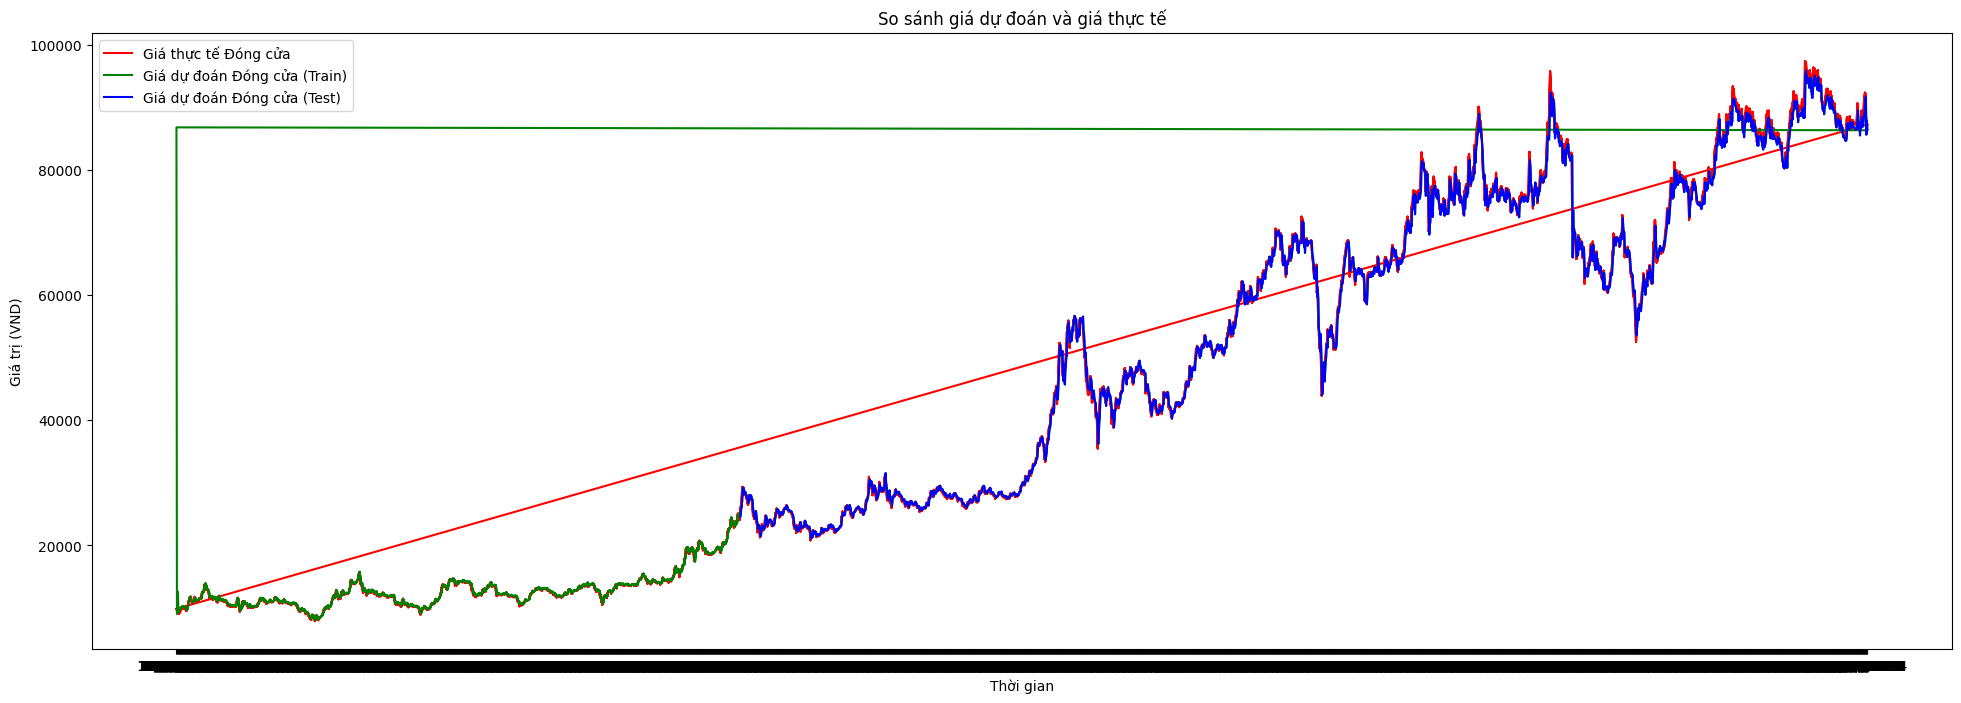

In [20]:
def bieudo3tap():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Price'], label="Giá thực tế Đóng cửa", color='red')
    #plt.plot(df1['Open'], label="Giá thực tế Mở cửa", color='orange')
    #plt.plot(df1['High'], label="Giá thực tế Cao nhất", color='purple')
    #plt.plot(df1['Low'], label="Giá thực tế Thấp nhất", color='brown')

    plt.plot(train_data_1['Dự đoán Đóng cửa'], label='Giá dự đoán Đóng cửa (Train)', color='green')
    plt.plot(test_data_1['Dự đoán Đóng cửa'], label='Giá dự đoán Đóng cửa (Test)', color='blue')

    plt.title("So sánh giá dự đoán và giá thực tế")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()
bieudo3tap()




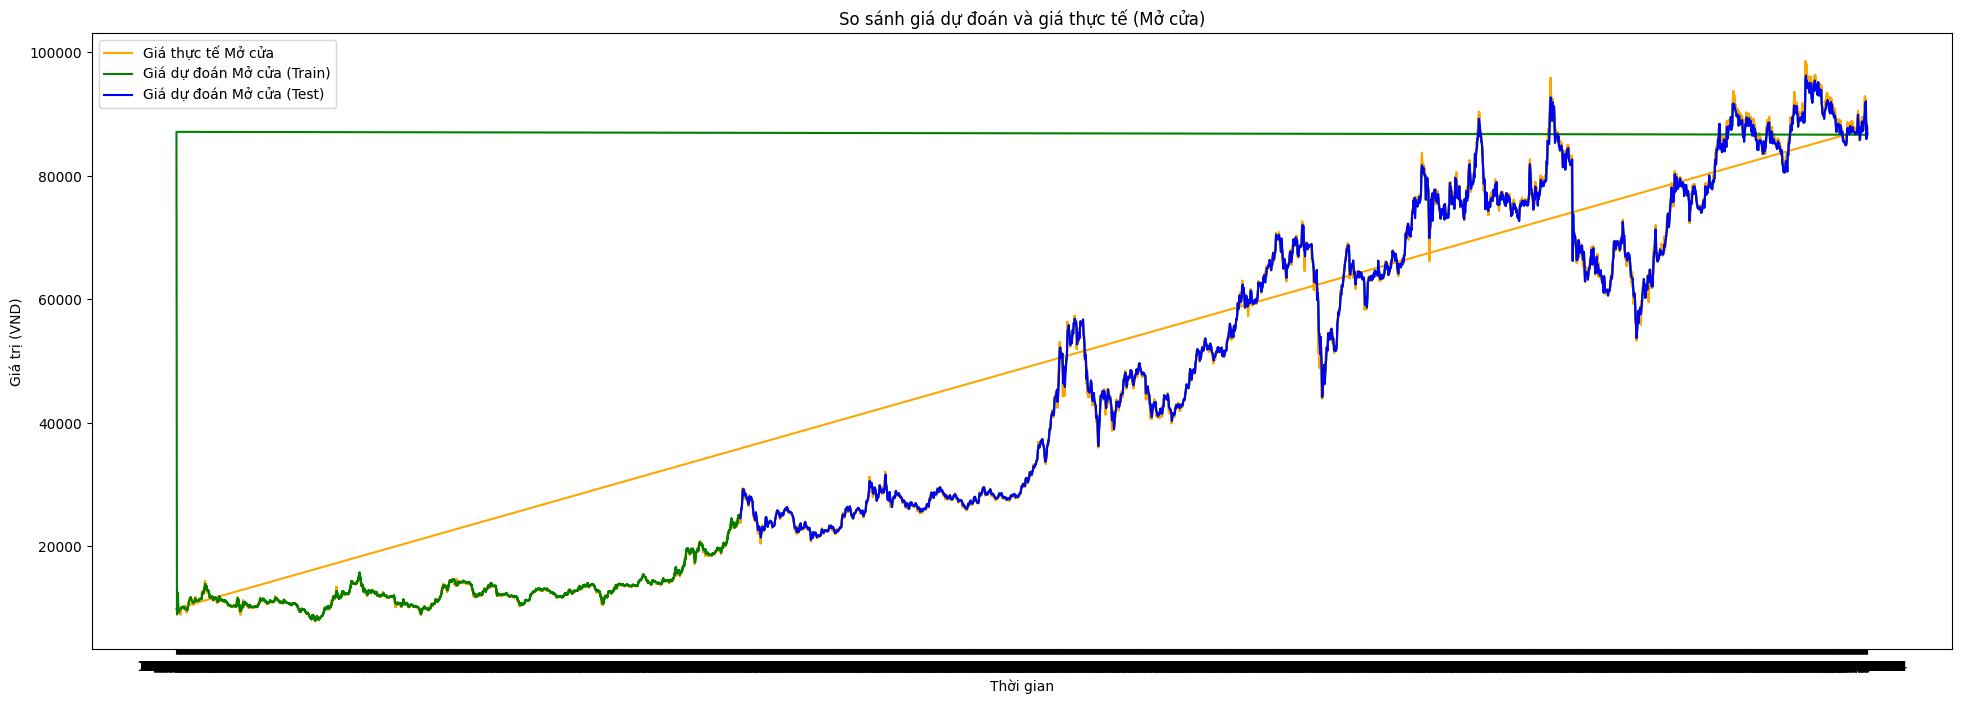

In [21]:

def bieudo_mo_cua():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Open'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Mở cửa'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Mở cửa'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_mo_cua()

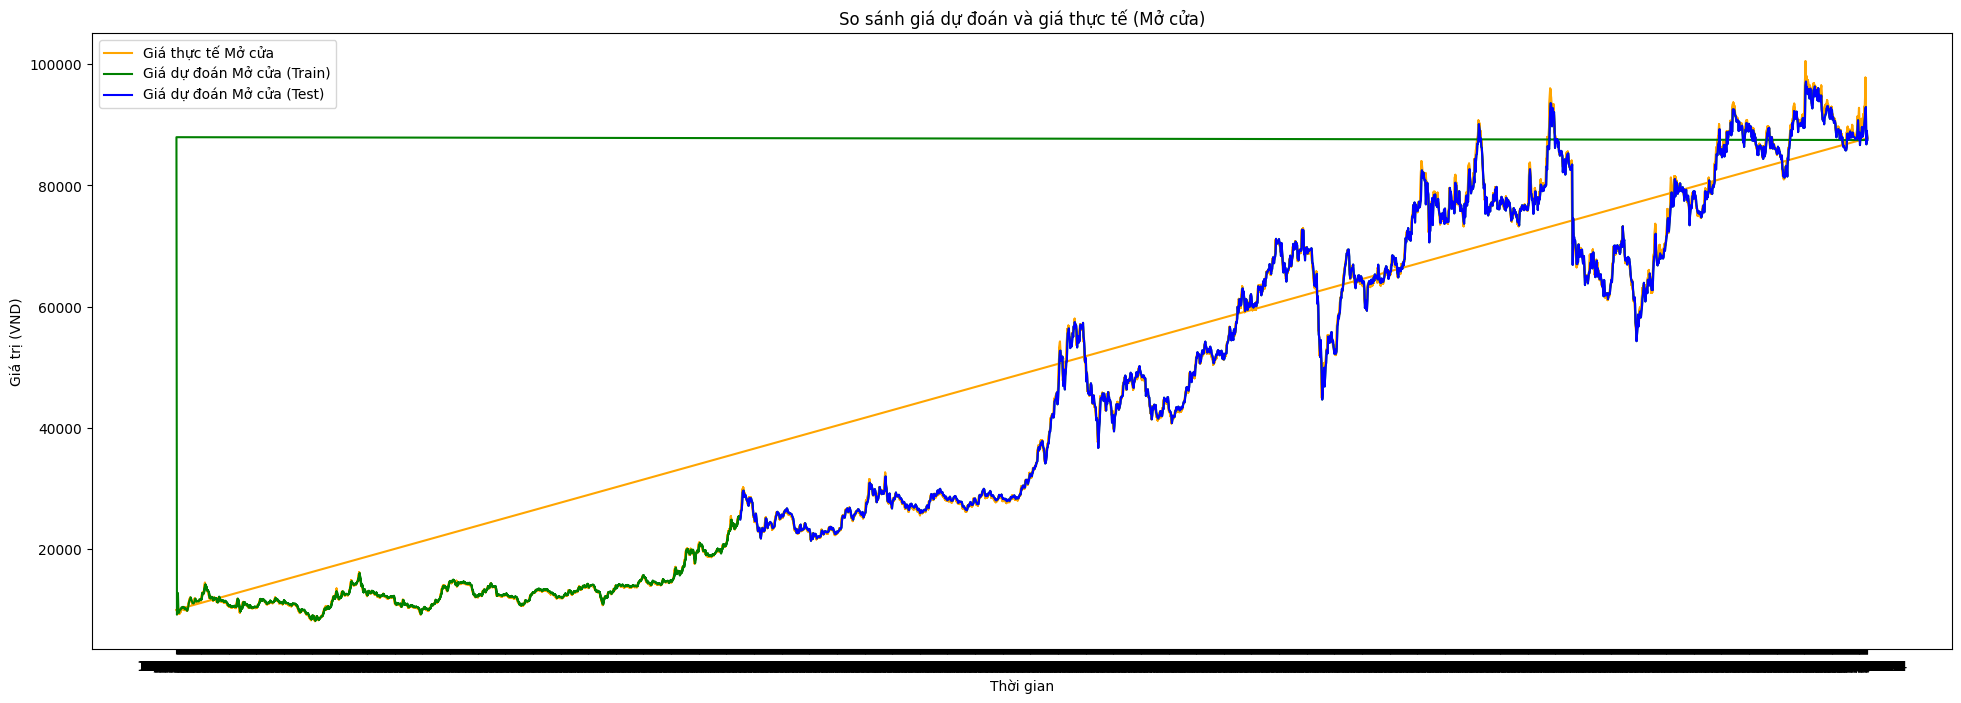

In [22]:

def bieudo_cao_nhat():
    plt.figure(figsize=(24,8))
    plt.plot(df1['High'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Cao nhất'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Cao nhất'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_cao_nhat()

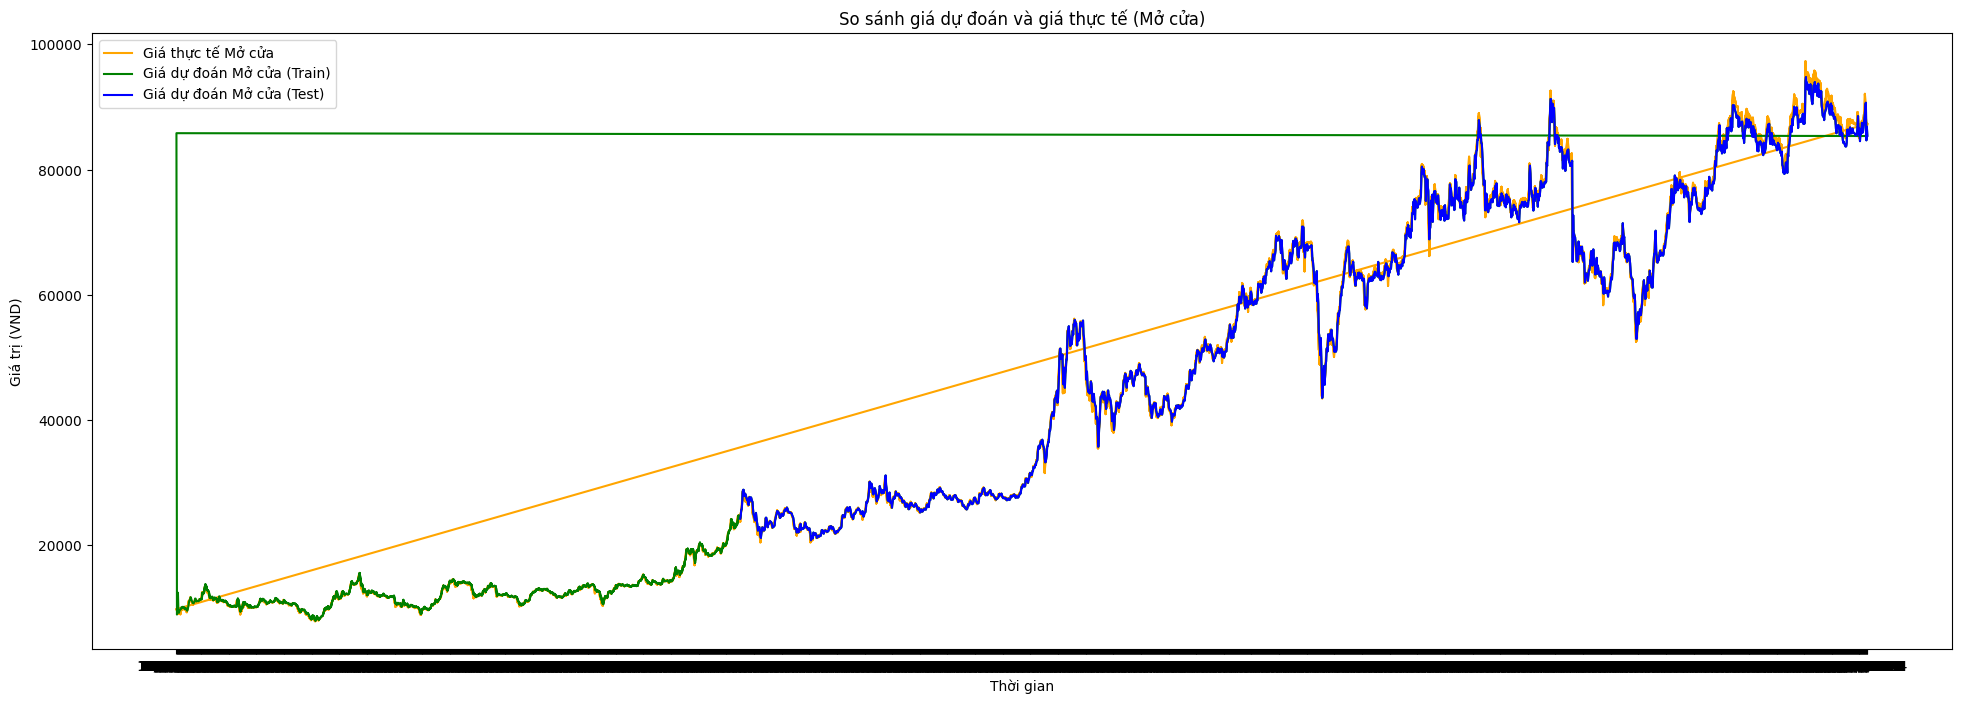

In [23]:

def bieudo_thap_nhat():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Low'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Thấp nhất'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Thấp nhất'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_thap_nhat()

In [24]:
train_data_1 = pd.DataFrame({
    'Price Đóng cửa': y_train[:, 0].flatten(),  # Giá thực tế Đóng cửa
    'Dự đoán Đóng cửa': y_train_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
    'Price Mở cửa': y_train[:, 1].flatten(),  # Giá thực tế Mở cửa
    'Dự đoán Mở cửa': y_train_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
    'Price Cao nhất': y_train[:, 2].flatten(),  # Giá thực tế Cao nhất
    'Dự đoán Cao nhất': y_train_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
    'Price Thấp nhất': y_train[:, 3].flatten(),  # Giá thực tế Thấp nhất
    'Dự đoán Thấp nhất': y_train_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
}, index=df1.index[50:a])  # Sử dụng index của dữ liệu gốc để tạo cột Date

# Hiển thị bảng so sánh cho tập huấn luyện
print(train_data_1.head())


            Price Đóng cửa  Dự đoán Đóng cửa  Price Mở cửa  Dự đoán Mở cửa  \
Date                                                                         
20/01/2011         11434.0      11531.088867       11434.0    11478.327148   
21/01/2011         11979.0      11531.369141       11471.0    11478.631836   
24/01/2011         12560.0      11899.768555       12560.0    11848.395508   
25/01/2011         12415.0      12598.717773       12814.0    12549.987305   
26/01/2011         12451.0      12589.493164       12415.0    12540.793945   

            Price Cao nhất  Dự đoán Cao nhất  Price Thấp nhất  \
Date                                                            
20/01/2011         11471.0      11645.299805          11398.0   
21/01/2011         11979.0      11645.586914          11471.0   
24/01/2011         12560.0      12018.970703          12487.0   
25/01/2011         12814.0      12727.386719          12160.0   
26/01/2011         12487.0      12718.130859          12306.0  

In [25]:
test_data_1 = pd.DataFrame({
    'Price Đóng cửa': y_test[:, 0].flatten(),  # Giá thực tế Đóng cửa
    'Dự đoán Đóng cửa': y_test_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
    'Price Mở cửa': y_test[:, 1].flatten(),  # Giá thực tế Mở cửa
    'Dự đoán Mở cửa': y_test_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
    'Price Cao nhất': y_test[:, 2].flatten(),  # Giá thực tế Cao nhất
    'Dự đoán Cao nhất': y_test_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
    'Price Thấp nhất': y_test[:, 3].flatten(),  # Giá thực tế Thấp nhất
    'Dự đoán Thấp nhất': y_test_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
}, index=df1.index[a:])  # Sử dụng index của dữ liệu gốc để tạo cột Date

# Hiển thị bảng so sánh cho tập kiểm tra
print(test_data_1.head())


            Price Đóng cửa  Dự đoán Đóng cửa  Price Mở cửa  Dự đoán Mở cửa  \
Date                                                                         
29/06/2015           25324      24554.140625         23815    24553.566406   
30/06/2015           26294      24968.582031         25109    24969.468750   
01/07/2015           26132      26000.162109         26294    26004.773438   
02/07/2015           27749      26066.085938         26078    26070.958984   
03/07/2015           29365      27268.021484         27749    27277.343750   

            Price Cao nhất  Dự đoán Cao nhất  Price Thấp nhất  \
Date                                                            
29/06/2015           25432      24846.115234            23762   
30/06/2015           26348      25266.166016            25109   
01/07/2015           26348      26311.654297            25486   
02/07/2015           27749      26378.519531            26025   
03/07/2015           29635      27596.666016            27749  

In [26]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate_predictions(y_true, y_pred, name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"Đánh giá độ chính xác cho {name}:")
    print(f"R^2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print()
#Phù hợp tập test
print("Độ phù hợp tập test: ", 'R^2')
print("Sai số tuyệt đối trung bình tập test: ", 'MAE')
print("Phần trăm sai số tuyệt đối trung bình tập test: ", 'MAPE\n')

#Price Đóng cửa vừa tạo bên trên lấy data từ Price cũ
# Đánh giá trên tập huấn luyện
evaluate_predictions(train_data_1['Price Đóng cửa'], train_data_1['Dự đoán Đóng cửa'], "Đóng cửa (Train)")
evaluate_predictions(train_data_1['Price Mở cửa'], train_data_1['Dự đoán Mở cửa'], "Mở cửa (Train)")
evaluate_predictions(train_data_1['Price Cao nhất'], train_data_1['Dự đoán Cao nhất'], "Cao nhất (Train)")
evaluate_predictions(train_data_1['Price Thấp nhất'], train_data_1['Dự đoán Thấp nhất'], "Thấp nhất (Train)")

# Đánh giá trên tập kiểm tra
evaluate_predictions(test_data_1['Price Đóng cửa'], test_data_1['Dự đoán Đóng cửa'], "Đóng cửa (Test)")
evaluate_predictions(test_data_1['Price Mở cửa'], test_data_1['Dự đoán Mở cửa'], "Mở cửa (Test)")
evaluate_predictions(test_data_1['Price Cao nhất'], test_data_1['Dự đoán Cao nhất'], "Cao nhất (Test)")
evaluate_predictions(test_data_1['Price Thấp nhất'], test_data_1['Dự đoán Thấp nhất'], "Thấp nhất (Test)")


Độ phù hợp tập test:  R^2
Sai số tuyệt đối trung bình tập test:  MAE
Phần trăm sai số tuyệt đối trung bình tập test:  MAPE

Đánh giá độ chính xác cho Đóng cửa (Train):
R^2: 0.9973
MAE: 536.0557
MAPE: 0.0180%

Đánh giá độ chính xác cho Mở cửa (Train):
R^2: 0.9979
MAE: 319.8276
MAPE: 0.0111%

Đánh giá độ chính xác cho Cao nhất (Train):
R^2: 0.9976
MAE: 421.8049
MAPE: 0.0148%

Đánh giá độ chính xác cho Thấp nhất (Train):
R^2: 0.9975
MAE: 451.3540
MAPE: 0.0142%

Đánh giá độ chính xác cho Đóng cửa (Test):
R^2: 0.9974
MAE: 799.9611
MAPE: 0.0142%

Đánh giá độ chính xác cho Mở cửa (Test):
R^2: 0.9989
MAE: 471.2263
MAPE: 0.0082%

Đánh giá độ chính xác cho Cao nhất (Test):
R^2: 0.9983
MAE: 608.8268
MAPE: 0.0109%

Đánh giá độ chính xác cho Thấp nhất (Test):
R^2: 0.9980
MAE: 704.9794
MAPE: 0.0120%



In [27]:

train_data_1.to_csv('file_test.csv')
test_data_1.to_csv('file_test.csv')



In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import schedule
import time
from kafka import KafkaConsumer
import io  # Thêm dòng này để import thư viện io

# Đường dẫn đến tệp mô hình đã lưu
save_model = "save_model_multi_output.hdf5"

# Định nghĩa hàm get_kafka
def get_kafka():
    # Thời gian chờ (giây)
    timeout_duration = 10

    # Tạo Kafka Consumer
    consumer = KafkaConsumer(
        "n6_sic",
        bootstrap_servers='localhost:9092',
        auto_offset_reset='earliest',
        enable_auto_commit=False
    )

    # Danh sách để lưu trữ các tin nhắn
    messages = []

    # Thời gian bắt đầu
    start_time = time.time()

    # Vòng lặp để đọc tin nhắn
    while True:
        # Lấy tin nhắn từ Kafka
        new_messages = consumer.poll(timeout_ms=1000)
        
        # Kiểm tra xem có tin nhắn mới không
        if new_messages:
            for topic_partition, messages_batch in new_messages.items():
                for message in messages_batch:
                    messages.append(message.value.decode('utf-8'))
            # Đặt lại thời gian bắt đầu khi có tin nhắn mới
            start_time = time.time()
        else:
            # Kiểm tra xem có vượt quá thời gian chờ không
            elapsed_time = time.time() - start_time
            if elapsed_time > timeout_duration:
                break

    # Chuyển danh sách tin nhắn thành DataFrame
    data = "\n".join(messages)
    df = pd.read_csv(io.StringIO(data), header=None)

    # Xóa dòng đầu tiên (tiêu đề cột không mong muốn)
    df = df.iloc[1:].reset_index(drop=True)

    # Xem số cột và tên cột hiện tại
    #print("Số cột hiện có:", len(df.columns))
    #print(df.head())

    # Xóa các dòng chứa tiêu đề không mong muốn
    df = df[~df.iloc[:, 0].str.contains('Date', na=False)].reset_index(drop=True)

    # Giữ lại chỉ những cột cần thiết và bỏ cột thừa
    expected_columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.']
    if len(df.columns) >= len(expected_columns):
        # Giữ lại các cột cần thiết
        df = df.iloc[:, :len(expected_columns)]
        df.columns = expected_columns

        # Đảm bảo các cột là kiểu dữ liệu string trước khi chuyển đổi
        df = df.astype(str)

        # Loại bỏ ký tự không hợp lệ như dấu phẩy
        df['Price'] = df['Price'].str.replace(',', '')
        df['Open'] = df['Open'].str.replace(',', '')
        df['High'] = df['High'].str.replace(',', '')
        df['Low'] = df['Low'].str.replace(',', '')
        df['Vol.'] = df['Vol.'].str.replace(',', '')

        # Chuyển đổi các cột giá từ chuỗi sang số, với kiểm tra lỗi
        df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
        df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
        df['High'] = pd.to_numeric(df['High'], errors='coerce')
        df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
        df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

        # Chuyển đổi cột ngày tháng
        #df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
        #print(df['Date'].head(20))  # Kiểm tra lại kết quả sau khi chuyển đổi

        # Xử lý giá trị NaN nếu cần
        #df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill

        # Hiển thị DataFrame sau khi tiền xử lý
        #df=df[::-1]
        #df = df.drop_duplicates(subset=['Date'])
        #Reset lại chỉ số sau khi xóa các giá trị trùng lặp!
        df = df.reset_index(drop=True)
        df = df.drop(columns=['Vol.'])
        #print(df)
        return df
    else:
        print("Dữ liệu không đủ để xử lý")
    pass

def save_to_csv(train_data_1, test_data_1, file_name='file_test.csv'):
    try:
        # Kiểm tra xem file CSV có tồn tại và không trống
        try:
            existing_data = pd.read_csv(file_name, index_col=0)
            header = False  # Không ghi lại tiêu đề nếu file đã tồn tại
        except (FileNotFoundError, pd.errors.EmptyDataError):
            existing_data = pd.DataFrame()
            header = True  # Ghi tiêu đề nếu file chưa tồn tại

        # Kết hợp train_data_1 và test_data_1
        combined_data = pd.concat([train_data_1, test_data_1])

        # Kiểm tra và chỉ giữ lại những dòng chưa tồn tại trong file hiện tại
        if not existing_data.empty:
            combined_data = combined_data.loc[~combined_data.index.isin(existing_data.index)]

        # Chèn dữ liệu mới vào file CSV
        combined_data.to_csv(file_name, mode='a', header=header)

        print(f"Dữ liệu mới đã được lưu vào {file_name}")
    except Exception as e:
        print(f"Đã xảy ra lỗi khi lưu dữ liệu: {e}")





def predict_daily():
    df=get_kafka()
    m=len(df)
    a= int((m*2)//3)
    b=int(m-a)
    # Sử dụng tất cả các cột cần dự đoán
    df1 = pd.DataFrame(data=df, columns=['Date', 'Price', 'Open', 'High', 'Low'])
    df1.index = df1.Date
    df1.drop('Date', axis=1, inplace=True)
    df1.head()
        # Lấy dữ liệu và chuẩn hóa
    data = df1.values
    train_data = data[:a]  # Dữ liệu huấn luyện
    test_data = data[a:]  # Dữ liệu kiểm tra

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)
    # Tạo dữ liệu x_train và y_train cho nhiều cột
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i-50:i])  # Lấy toàn bộ cột dữ liệu
        y_train.append(sc_train[i])

    # Chuyển đổi thành numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

        # Sau khi hoàn tất huấn luyện, bạn có thể tải mô hình tốt nhất đã lưu để sử dụng
    final_model = load_model(save_model)  # Tải mô hình đã lưu
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train)

    # Xử lý dữ liệu test
    columns_to_convert = ['Price', 'Open', 'High', 'Low']
    test = df1[len(train_data)-50:].values
    test = test.reshape(-1, len(columns_to_convert))
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i-50:i])

    x_test = np.array(x_test)
    y_test = data[a:]  # Giá thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)

    train_data_1 = df1[50:a]
    test_data_1 = df1[a:]
    train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
    test_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_test_predict
    test_data_1 = pd.DataFrame({
        'Price Đóng cửa': y_test[:, 0].flatten(),  # Giá thực tế Đóng cửa
        'Dự đoán Đóng cửa': y_test_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
        'Price Mở cửa': y_test[:, 1].flatten(),  # Giá thực tế Mở cửa
        'Dự đoán Mở cửa': y_test_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
        'Price Cao nhất': y_test[:, 2].flatten(),  # Giá thực tế Cao nhất
        'Dự đoán Cao nhất': y_test_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
        'Price Thấp nhất': y_test[:, 3].flatten(),  # Giá thực tế Thấp nhất
        'Dự đoán Thấp nhất': y_test_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
    }, index=df1.index[a:])  # Sử dụng index của dữ liệu gốc để tạo cột Date

    train_data_1 = pd.DataFrame({
        'Price Đóng cửa': y_train[:, 0].flatten(),  # Giá thực tế Đóng cửa
        'Dự đoán Đóng cửa': y_train_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
        'Price Mở cửa': y_train[:, 1].flatten(),  # Giá thực tế Mở cửa
        'Dự đoán Mở cửa': y_train_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
        'Price Cao nhất': y_train[:, 2].flatten(),  # Giá thực tế Cao nhất
        'Dự đoán Cao nhất': y_train_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
        'Price Thấp nhất': y_train[:, 3].flatten(),  # Giá thực tế Thấp nhất
        'Dự đoán Thấp nhất': y_train_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
    }, index=df1.index[50:a])  # Sử dụng index của dữ liệu gốc để tạo cột Date
    # Gọi hàm để lưu dữ liệu
    save_to_csv(train_data_1, test_data_1)


#predict_daily()

def job():
    print("Đang thực hiện dự đoán...")
    predict_daily()
    print("Dự đoán hoàn tất!")
# Lên lịch chạy công việc mỗi ngày vào một giờ nhất định, ví dụ 9:00 sáng
#schedule.every().day.at("22:45").do(job)
schedule.every(1).minutes.do(job)
while True:
    schedule.run_pending()
    time.sleep(60)  # Kiểm tra lịch trình mỗi phút

